In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Read and Visualize Data:

In this section the data is loaded and cleaned. Then, each feature is analyzed in terms `dtype`, unique values and distribution.

### Data loading and cleaning

Loading the data and extracting the main features (size, dtypes, missing values...)

In [3]:
df = pd.read_csv('./data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### QGIS - Classifing rbnbs by proximity to subway station

Later on in this study we will analyse the relation between the price and the distance to the nearest New York subway. The main feature used to extract this information was 'Service area'. This will be covered in the report. 


From QGIS we extracted the following datasets for each service area. We will merge them to our dataset appending a single column. This has been previously done and is available in a different file

In [4]:
# Colors to represent each of the ranges in figures
color_code = ['#63008A', '#B100B1', '#D80060', '#FF0200', '#F85A07', '#F2AA0E', '#E6EB14', '#9CE41B', '#5ADD22', '#28D72F', '#2FD06B']

`Disclaimer`: We do the merge this way in order to be able to personalize the order in whitch the different categories of subway_proximity are plotted:

In [5]:
subway_info = pd.read_csv('./data/subway_info.csv')

# Order in which we want each category to be represented
order = list(map(str, list(range(100, 1100, 100))))
order.append('else')

df['subway_proximity'] = pd.Categorical(subway_info['subway_proximity'], order)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_proximity
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,700
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,else
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,500
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,500
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,300


In [6]:
# Print dataset info
def print_dataset_info(df):
    num_rows, num_columns = df.shape

    print("========== DATASET INFO ==========")
    print(f"Number of entries: {num_rows}")
    print(f"Number of columns: {num_columns}")
    print()
    print(df.info())
    print()
    print("Missing value count:")
    print(df.isnull().sum())

In [7]:
print_dataset_info(df)

========== DATASET INFO ==========
Number of entries: 48895
Number of columns: 17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              48895 non-null  int64   
 1   name                            48879 non-null  object  
 2   host_id                         48895 non-null  int64   
 3   host_name                       48874 non-null  object  
 4   neighbourhood_group             48895 non-null  object  
 5   neighbourhood                   48895 non-null  object  
 6   latitude                        48895 non-null  float64 
 7   longitude                       48895 non-null  float64 
 8   room_type                       48895 non-null  object  
 9   price                           48895 non-null  int64   
 10  minimum_nights                  48895 non-null  int64   
 1

Roughly 1/5 of the dataset has nulls, let's get rid of them

In [8]:
clean_df = df.copy()
clean_df = clean_df.dropna()
print_dataset_info(clean_df)

========== DATASET INFO ==========
Number of entries: 38821
Number of columns: 17

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38821 entries, 0 to 48852
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              38821 non-null  int64   
 1   name                            38821 non-null  object  
 2   host_id                         38821 non-null  int64   
 3   host_name                       38821 non-null  object  
 4   neighbourhood_group             38821 non-null  object  
 5   neighbourhood                   38821 non-null  object  
 6   latitude                        38821 non-null  float64 
 7   longitude                       38821 non-null  float64 
 8   room_type                       38821 non-null  object  
 9   price                           38821 non-null  int64   
 10  minimum_nights                  38821 non-null  int64   
 1

In [9]:
#Set seaborn themes
#sns.set_theme(style="whitegrid")
sns.set_theme(style='darkgrid')
sns.set_color_codes("pastel")

The following function creates a histogram for a given feature and additionally compares the distribution with the original dataset to verify that the proportions haven't been significantly affected given the null delition.

In [10]:
def comparison_count(df1, df2, column, figsize=None, same_ordering=True):
    df1 = df1.groupby([column])[column].count().sort_values(ascending=False).head(50)
    df2 = df2.groupby([column])[column].count().sort_values(ascending=False).head(50)

    if figsize:
        f, ax = plt.subplots(1, 2, figsize=figsize, sharex=True)
    else:
        f, ax = plt.subplots(1, 2,sharex=True)
    
    order_plot_2 = df1.keys() if same_ordering else df2.keys()
    
    #Plot df1 dataset info
    ax[0].set_title("Raw dataset")
    ax[0].set_xlabel("Number of listigns")
    sns.barplot(x=df1.values, y=df1.keys(),
                label=column + " count", color="b", ax=ax[0], orient='h', order=df1.keys())
    ax[0].set_ylabel(column.capitalize())

    #Plot df2 dataset info
    ax[1].set_title("Clean dataset")
    ax[1].set_xlabel("Number of listigns")
    sns.barplot(x=df2.values, y=df2.keys(),
                label=column + "count", color="b", ax=ax[1], orient='h', order=order_plot_2)
    ax[1].set_ylabel(column.capitalize())

    
    plt.show()

### Feature visualization: `neighbourhood_group`

New York is divided in boroughs. Let's find out which ones are present in our dataset and how are they represented in terms of popularity.

In [11]:
print(f"New York boroughs: \n{clean_df.neighbourhood_group.unique()}")

New York boroughs: 
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


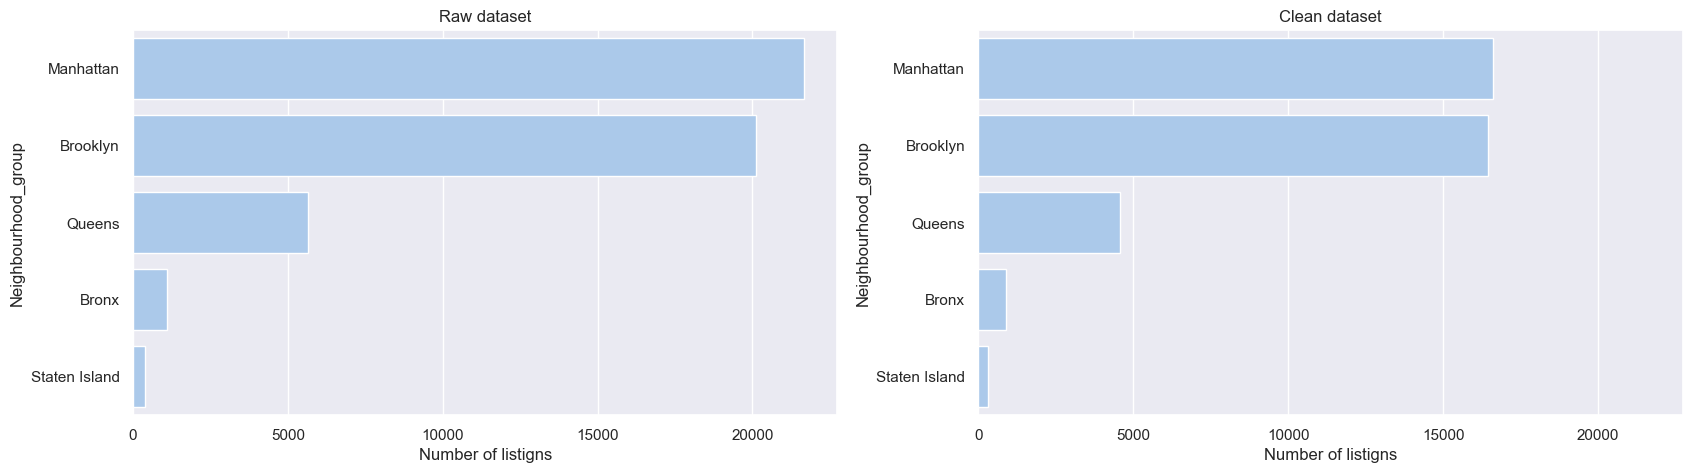

In [12]:
#Neighbourhood column exploration
comparison_count(df, clean_df, "neighbourhood_group", figsize=(20,5))

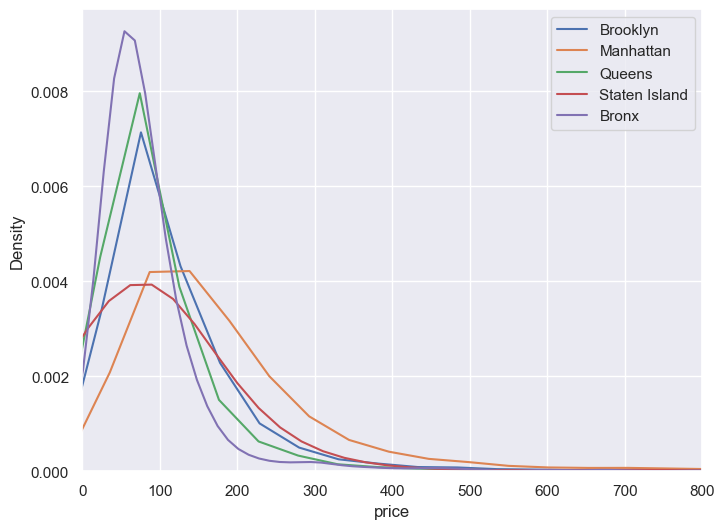

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
for borough in df.neighbourhood_group.unique():
    sns.kdeplot(df[df['neighbourhood_group'] == borough]['price'], ax=ax, label=borough)
ax.set_xlim(0, 800)
plt.legend()
plt.show()

Manhattan and Brooklyn are by far the most popular boroughs in our dataset. The overall distribution is not heavily affected when removing missing values.

### Feature visualization: `host_id`

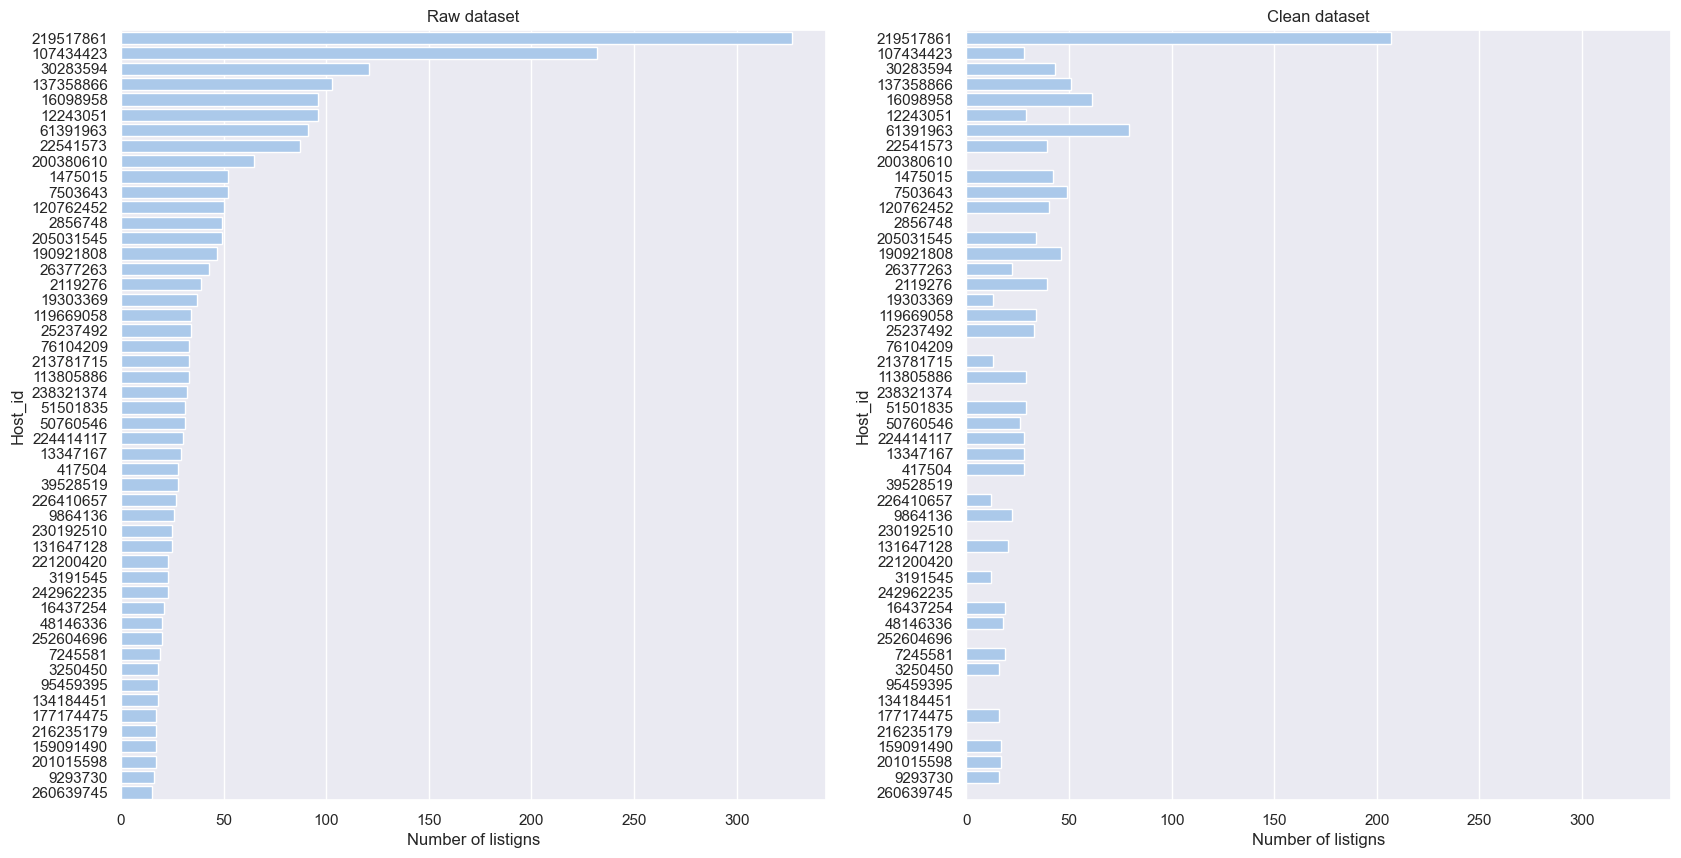

In [89]:
#Host column exploration
comparison_count(df, clean_df, "host_id", figsize=(20,10))

As we can see, few hosts accumulate most of the listings. These are probaly agencies or small companies that use this service as full-time job.

### Feature visualization: `room_type`

In [90]:
print(f"Room types available: \n{clean_df.room_type.unique()}")

Room types available: 
['Private room' 'Entire home/apt' 'Shared room']


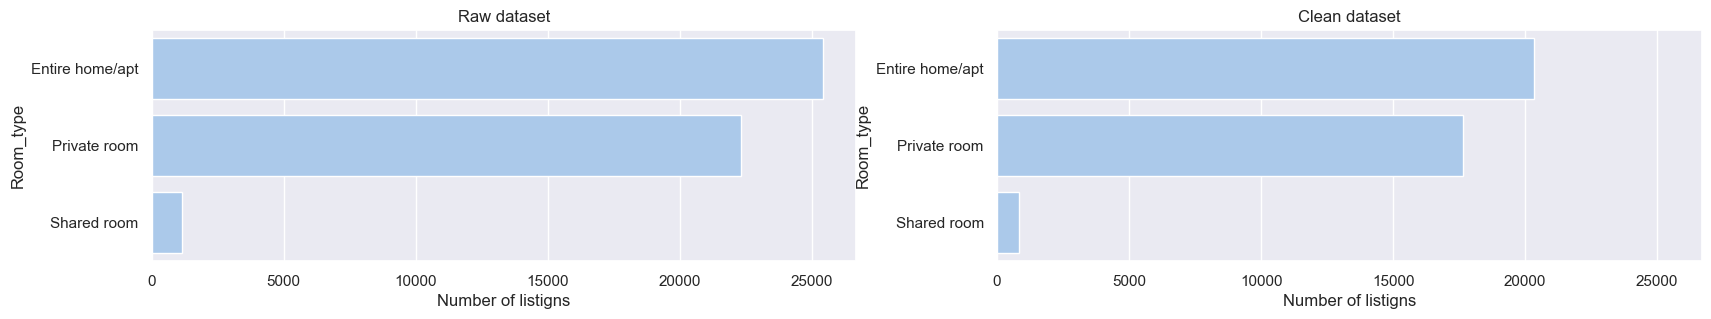

In [91]:
# Room Type column exploration
comparison_count(df, clean_df, "room_type", figsize=(20,3))

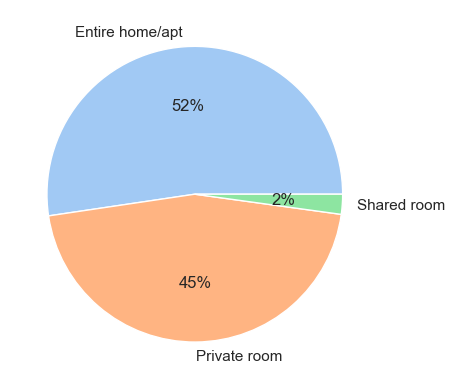

In [92]:
counts = clean_df['room_type'].value_counts()
colors = sns.color_palette('pastel')[0:5]
plt.pie(counts.values, labels = counts.index, colors = colors, autopct='%.0f%%')
plt.show()

### Feature visualization: `price`, `number_of_reviews`, `reviews_per_month`, `calculated_host_listings_count` and `availability`

In [31]:
def plot_hist_box(df, column ,ax_line, top_q=None, bot_q=None):

    if top_q:
        df = df[df[column] < df[column].quantile(top_q)]
    if bot_q:
        df = df[df[column] > df[column].quantile(bot_q)]

    sns.histplot(df[column], bins=45, kde=True, ax=ax_line[0])
    ax_line[0].set_title("Histogram")
    sns.boxplot(x=df[column], ax=ax_line[1], orient='h')
    ax_line[1].set_title("Boxplot")

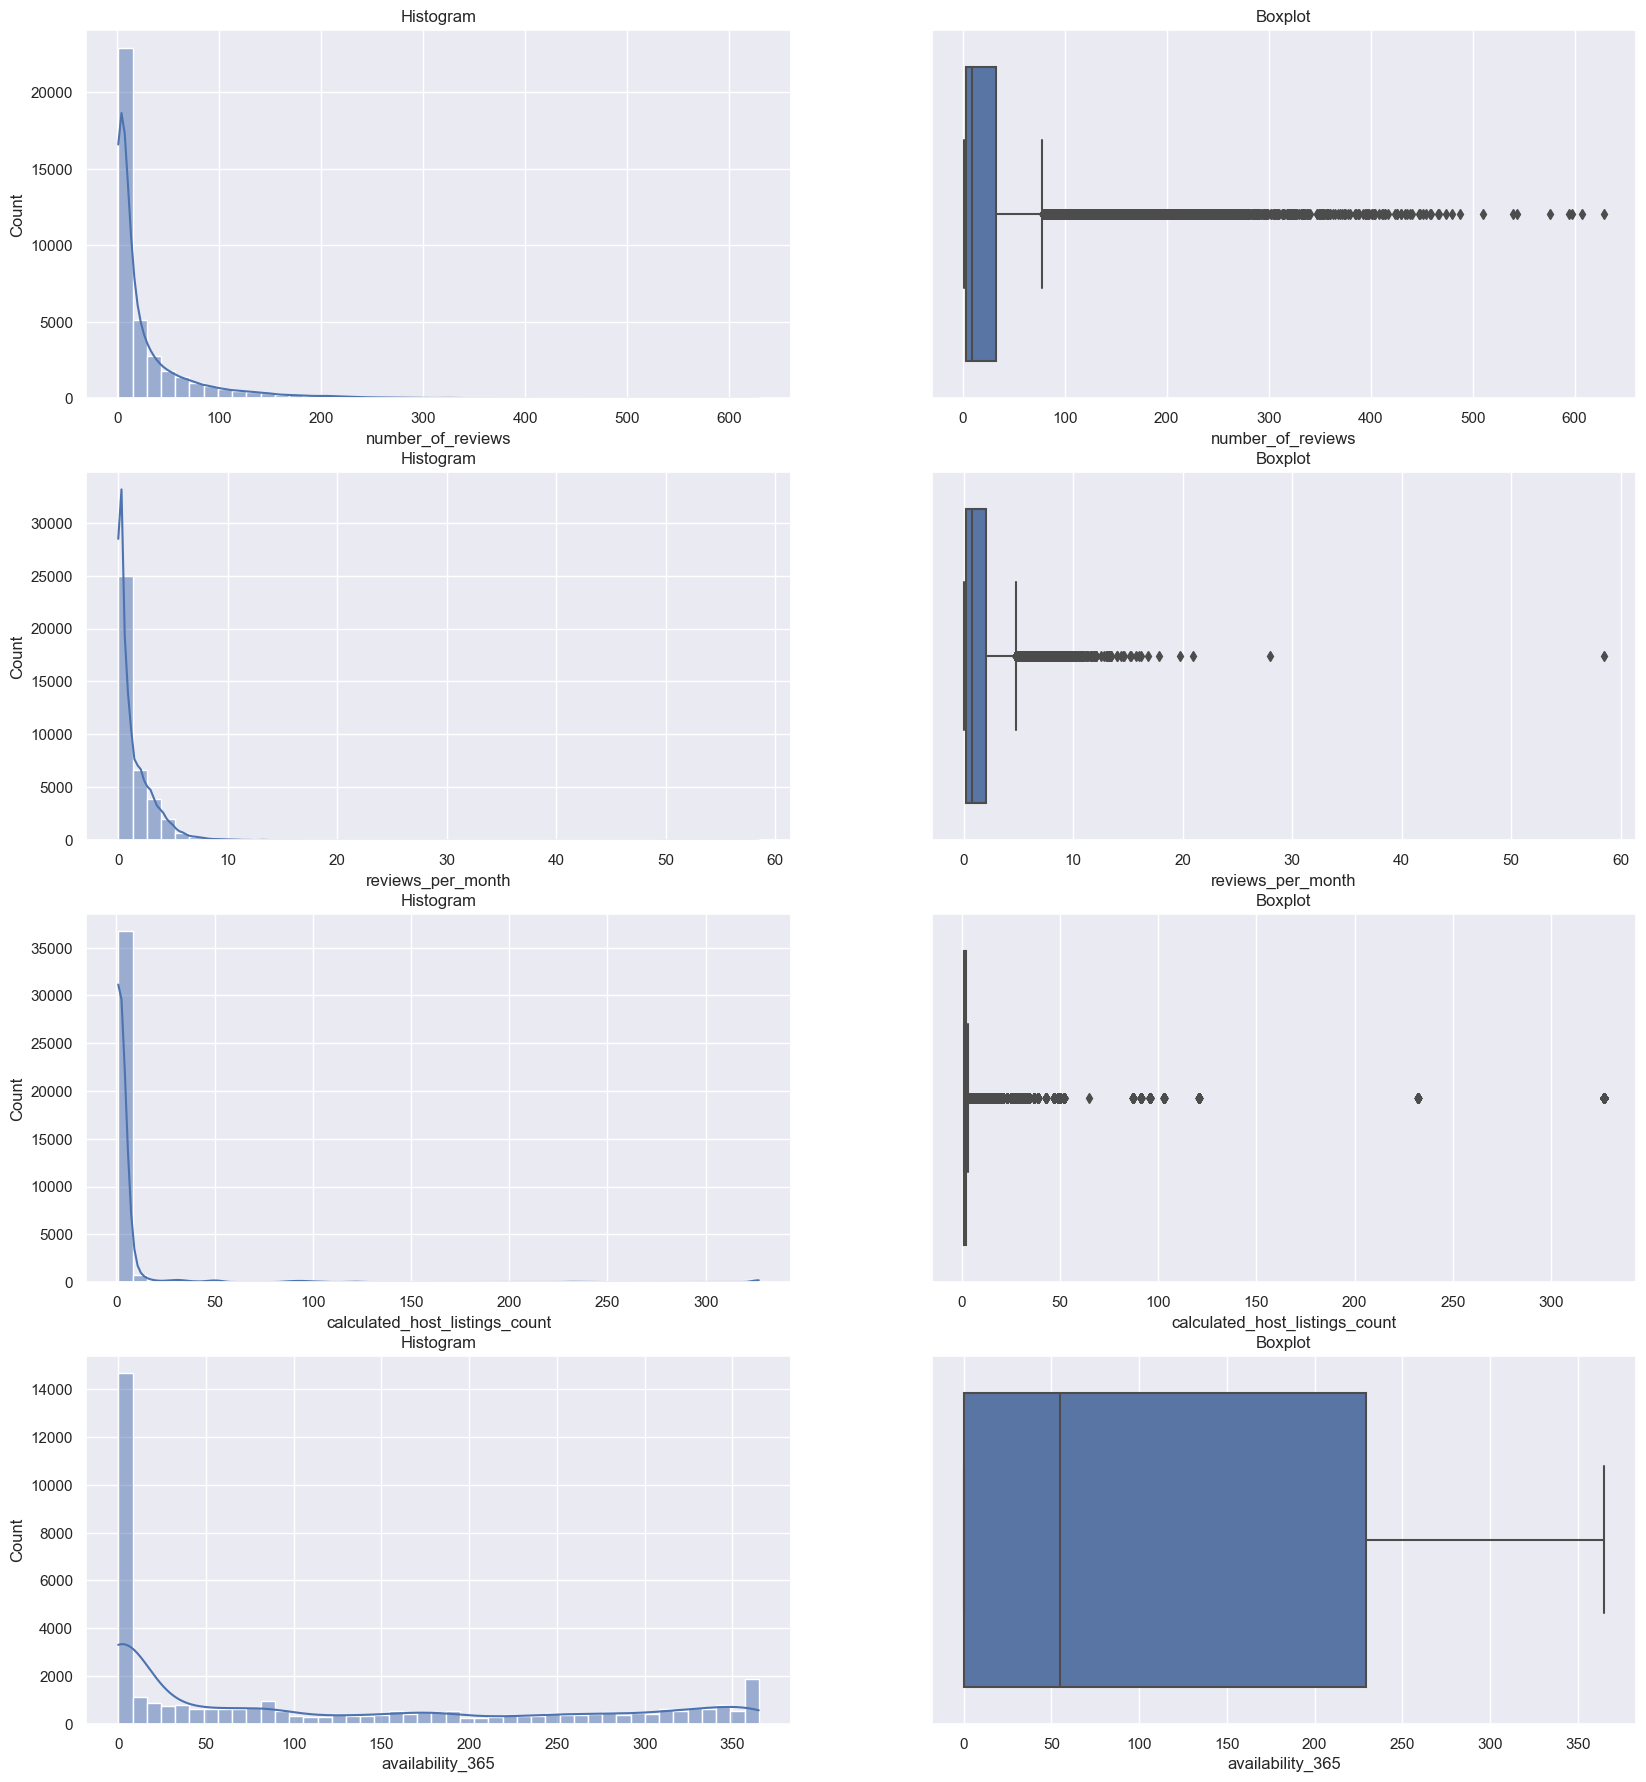

In [33]:
fig, ax = plt.subplots(4, 2, figsize=(20,22))
plot_hist_box(clean_df, 'number_of_reviews', ax_line=ax[0])
plot_hist_box(clean_df, 'reviews_per_month', ax_line=ax[1])
plot_hist_box(clean_df, 'calculated_host_listings_count', ax_line=ax[2])
plot_hist_box(clean_df, 'availability_365', ax_line=ax[3])
plt.show()

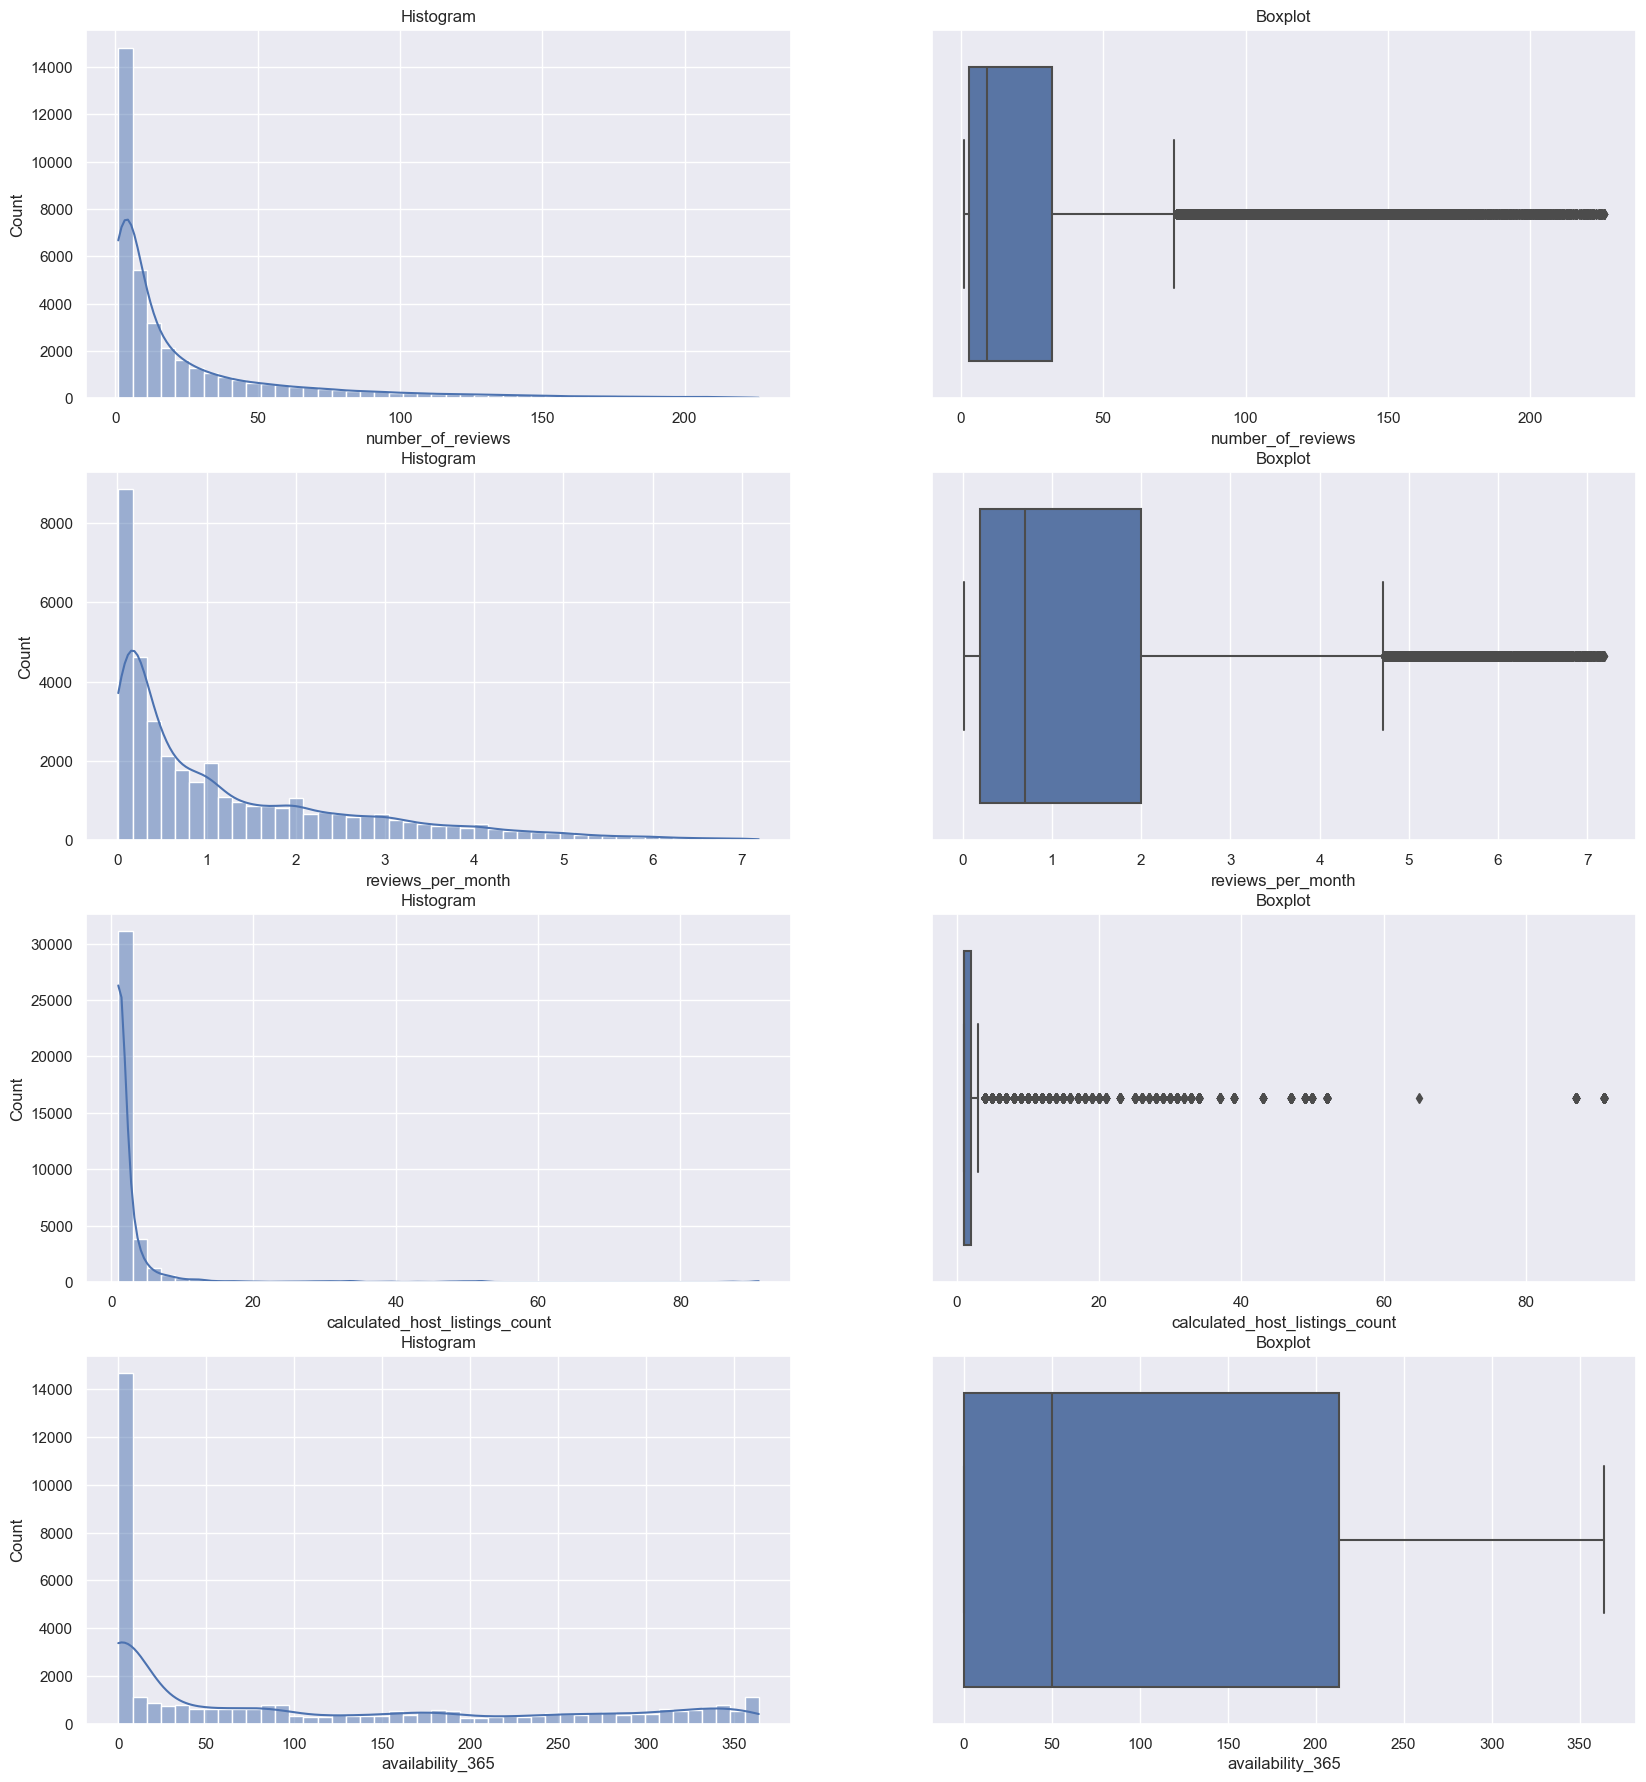

In [95]:
# Removing some outliers
fig, ax = plt.subplots(4, 2, figsize=(20,22))
plot_hist_box(clean_df, 'number_of_reviews', ax_line=ax[0], top_q=0.99)
plot_hist_box(clean_df, 'reviews_per_month', ax_line=ax[1], top_q=0.99)
plot_hist_box(clean_df, 'calculated_host_listings_count', ax_line=ax[2], top_q=0.99)
plot_hist_box(clean_df, 'availability_365', ax_line=ax[3], top_q=0.99)
plt.show()

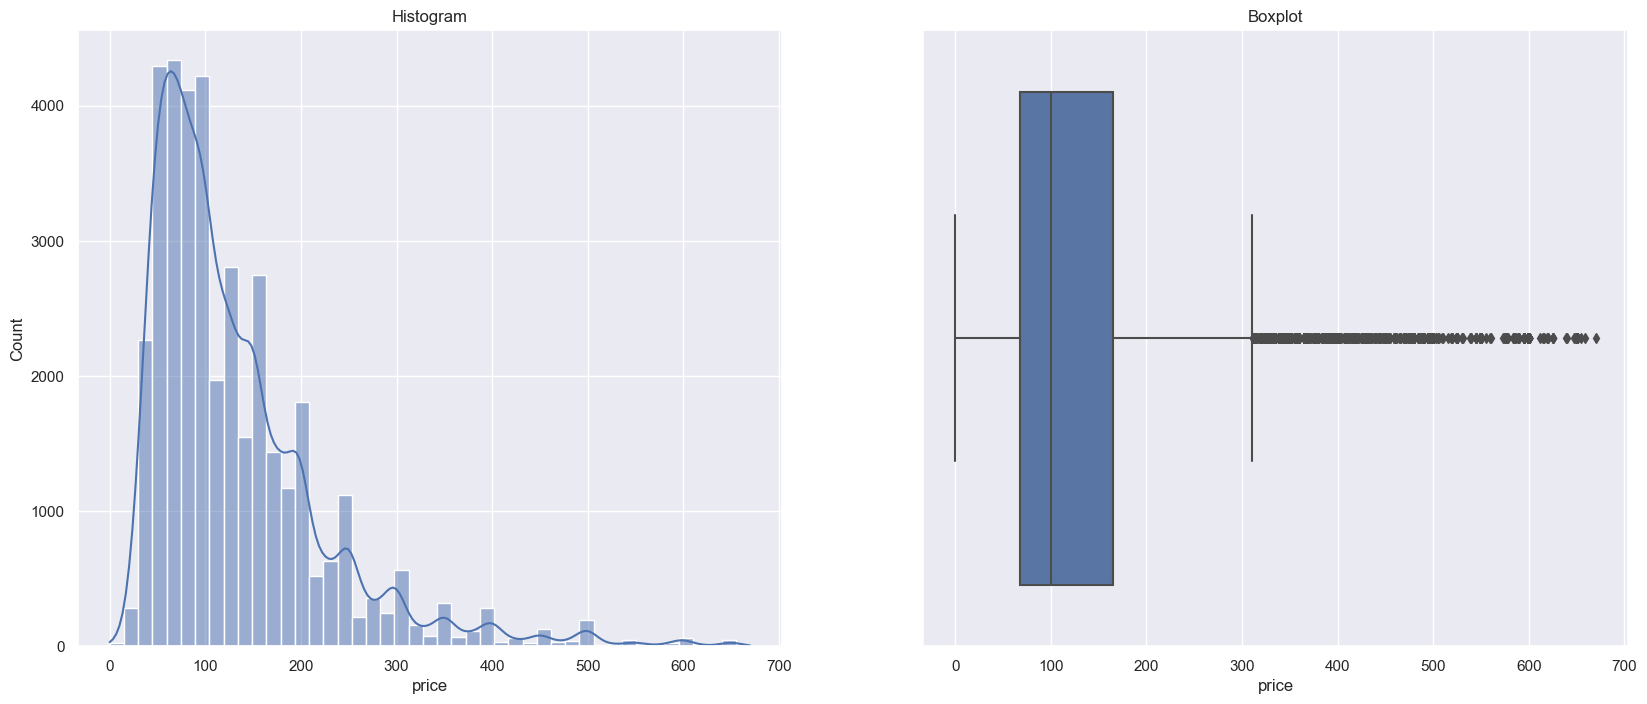

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_hist_box(clean_df, 'price', ax_line=ax, top_q=0.99)
plt.show()

In [97]:
print(f"Total average price of a lodging in New York: {round(clean_df['price'].mean(),2)}")

Total average price of a lodging in New York: 142.33


## 2. Data Analysis

### Relation between `price` and `neighbourhood_group`, `room_type`

In [98]:
print(f"{' Average price / borough ':=^70}")
display(pd.DataFrame(clean_df.groupby('neighbourhood_group')['price'].mean()))
print(f"{' Average price / room type ':=^70}")
display(pd.DataFrame(clean_df.groupby('room_type')['price'].mean()))
print(f"{' Average price / (room_type and borough) ':=^70}")
display(pd.DataFrame(clean_df.groupby(['room_type', 'neighbourhood_group'])['price'].mean()))

====================== Average price / borough =======================


,price
neighbourhood_group,
Bronx,79.558857
Brooklyn,121.463289
Manhattan,180.071596
Queens,95.783683
Staten Island,89.964968


===================== Average price / room type ======================


,price
room_type,
Entire home/apt,196.315929
Private room,83.985272
Shared room,63.213948


============== Average price / (room_type and borough) ===============


price
room_type       neighbourhood_group            
Entire home/apt Bronx                120.938312
                Brooklyn             171.281897
                Manhattan            230.200964
                Queens               139.225603
                Staten Island        125.366667
Private room    Bronx                 57.093511
                Brooklyn              73.349562
                Manhattan            106.607488
                Queens                69.302838
                Staten Island         57.584906
Shared room     Bronx                 56.930233
                Brooklyn              45.458621
                Manhattan             77.980337
                Queens                64.467105
                Staten Island         57.600000

### Relation between `price` and `reviews_per_month`

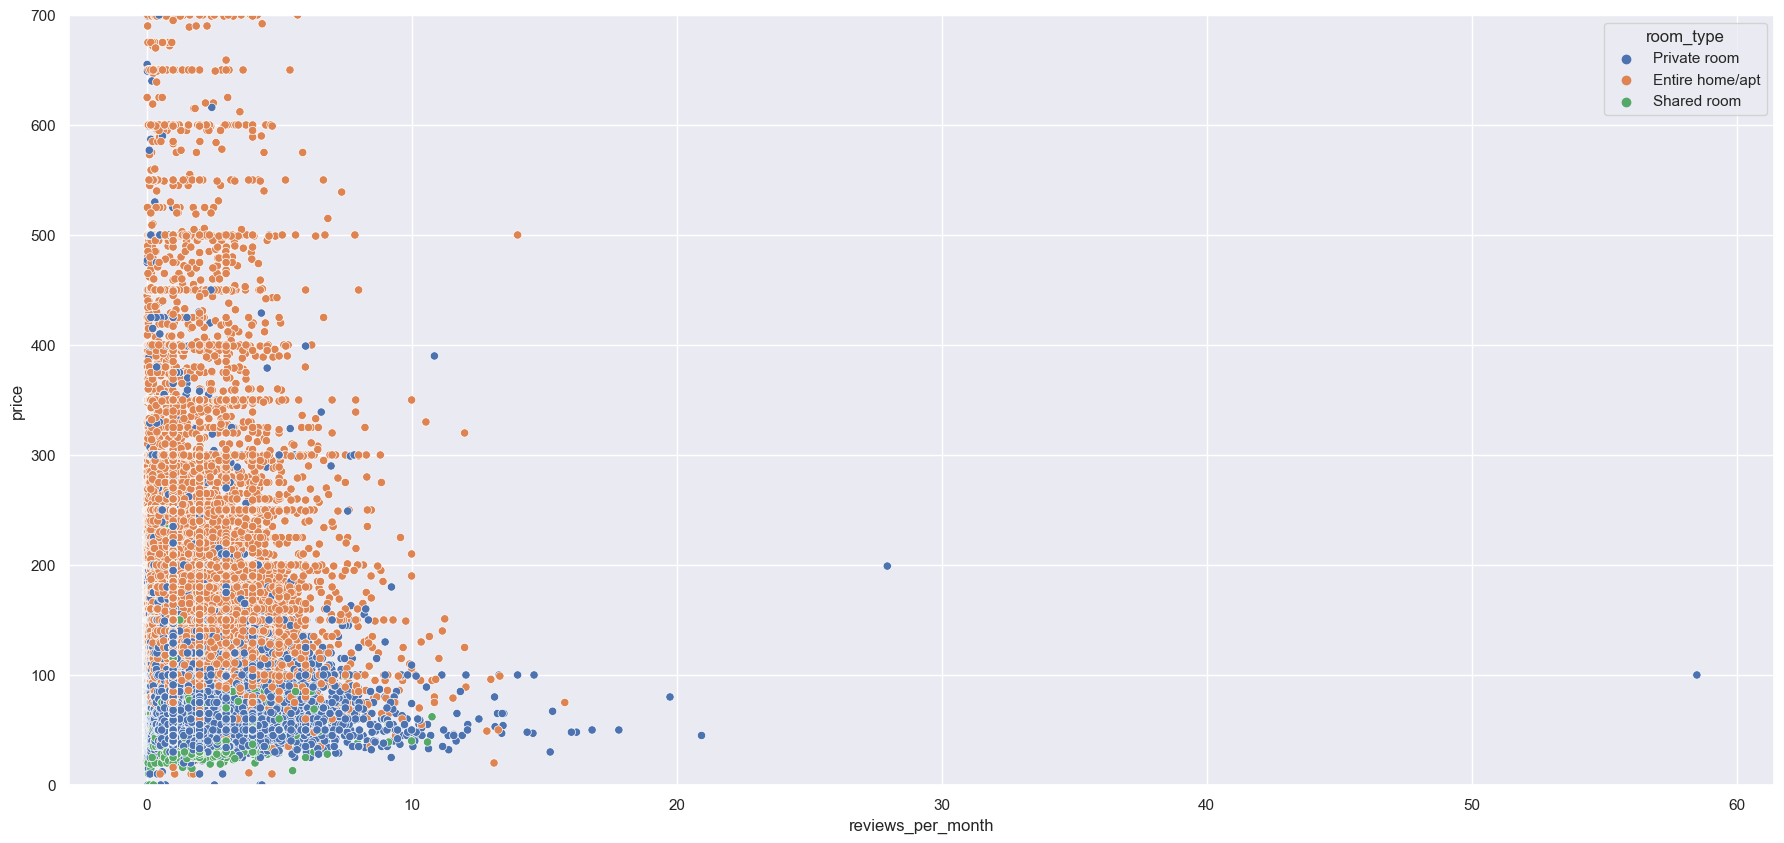

In [99]:
fig, ax = plt.subplots(1, figsize=(22,10))
ax.set_ylim(0, 700)
sns.scatterplot(clean_df, x='reviews_per_month', y='price', hue='room_type', ax=ax)
plt.show()

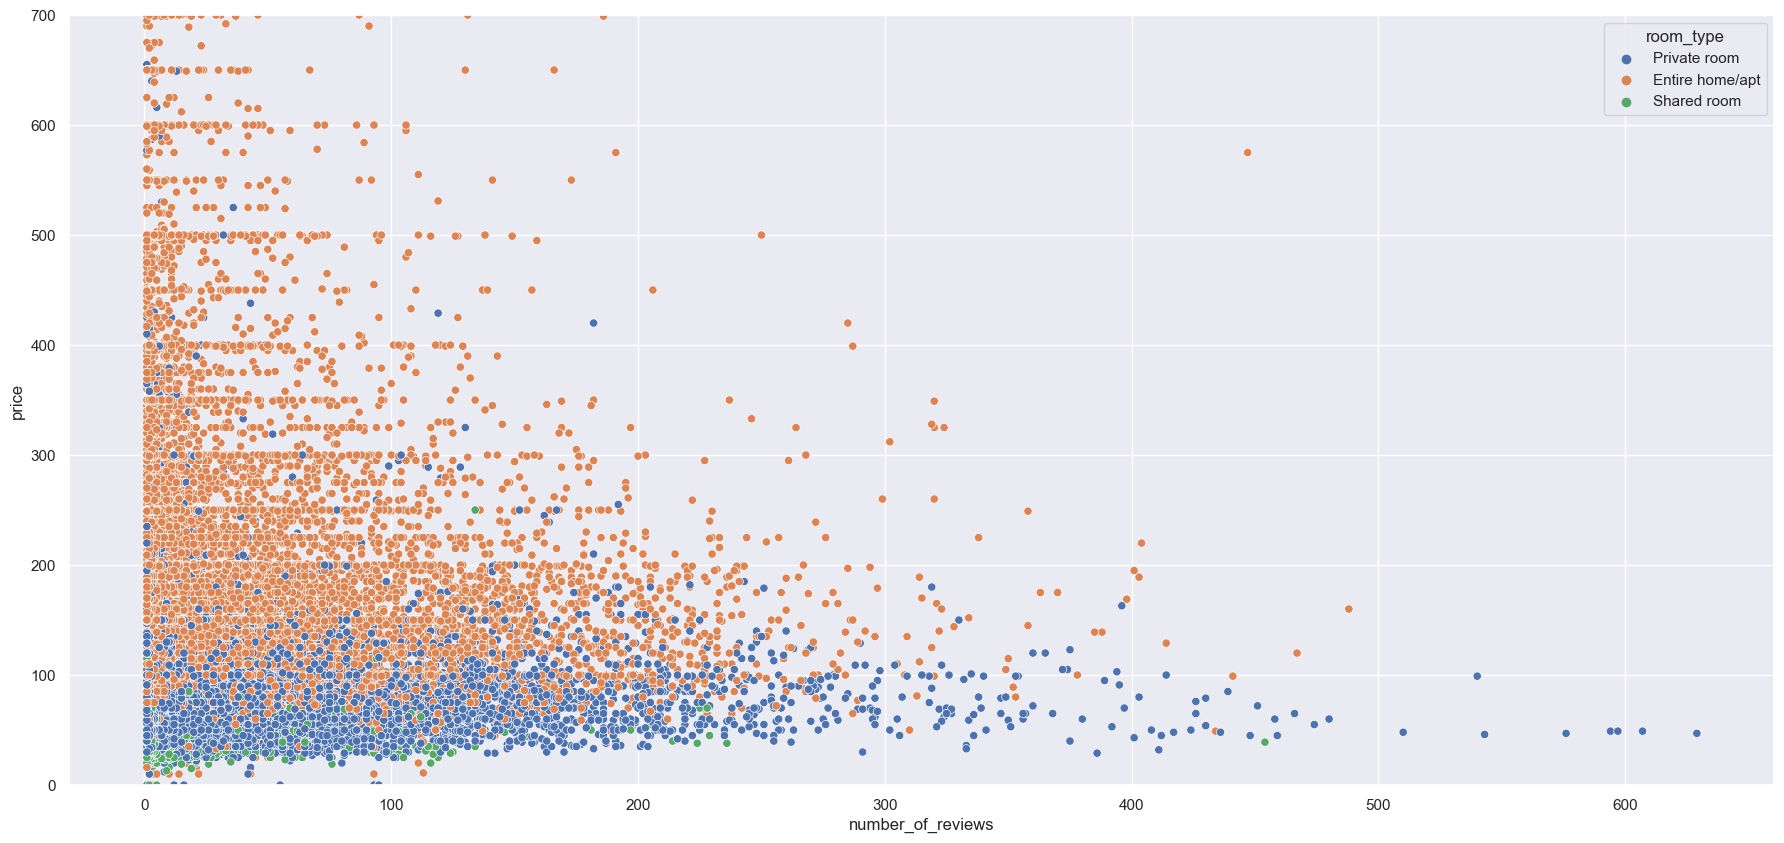

In [100]:
fig, ax = plt.subplots(1, figsize=(22,10))
ax.set_ylim(0, 700)
sns.scatterplot(clean_df, x='number_of_reviews', y='price', hue='room_type', ax=ax)
plt.show()

### Relation between `subway_proximity` and `price`

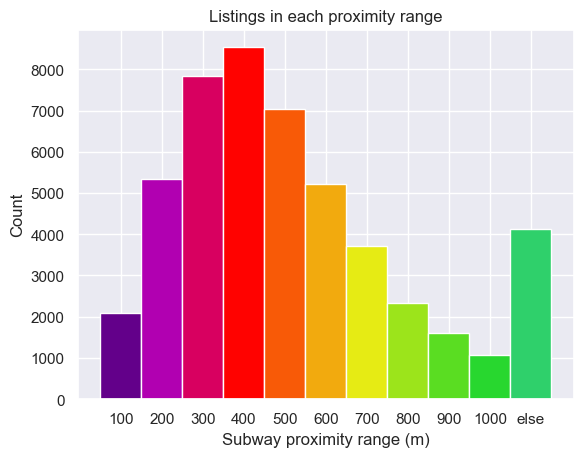

In [131]:
color_code = ['#63008A', '#B100B1', '#D80060', '#FF0200', '#F85A07', '#F2AA0E', '#E6EB14', '#9CE41B', '#5ADD22', '#28D72F', '#2FD06B']

fig, ax = plt.subplots(1,1)
sns.histplot(df.sort_values('subway_proximity'), x='subway_proximity')
plt.xlabel('Subway proximity range (m)')
plt.title('Listings in each proximity range')
for bar, color in zip(ax.patches, color_code):
    bar.set_facecolor(color)

plt.show()


df_100 = df[df['subway_proximity'] == '100']
df_200 = df[df['subway_proximity'] == '200']
df_300 = df[df['subway_proximity'] == '300']
df_400 = df[df['subway_proximity'] == '400']
df_500 = df[df['subway_proximity'] == '500']
df_600 = df[df['subway_proximity'] == '600']
df_700 = df[df['subway_proximity'] == '700']
df_800 = df[df['subway_proximity'] == '800']
df_900 = df[df['subway_proximity'] == '900']
df_1000 = df[df['subway_proximity'] == '1000']
df_else = df[df['subway_proximity'] == 'else']


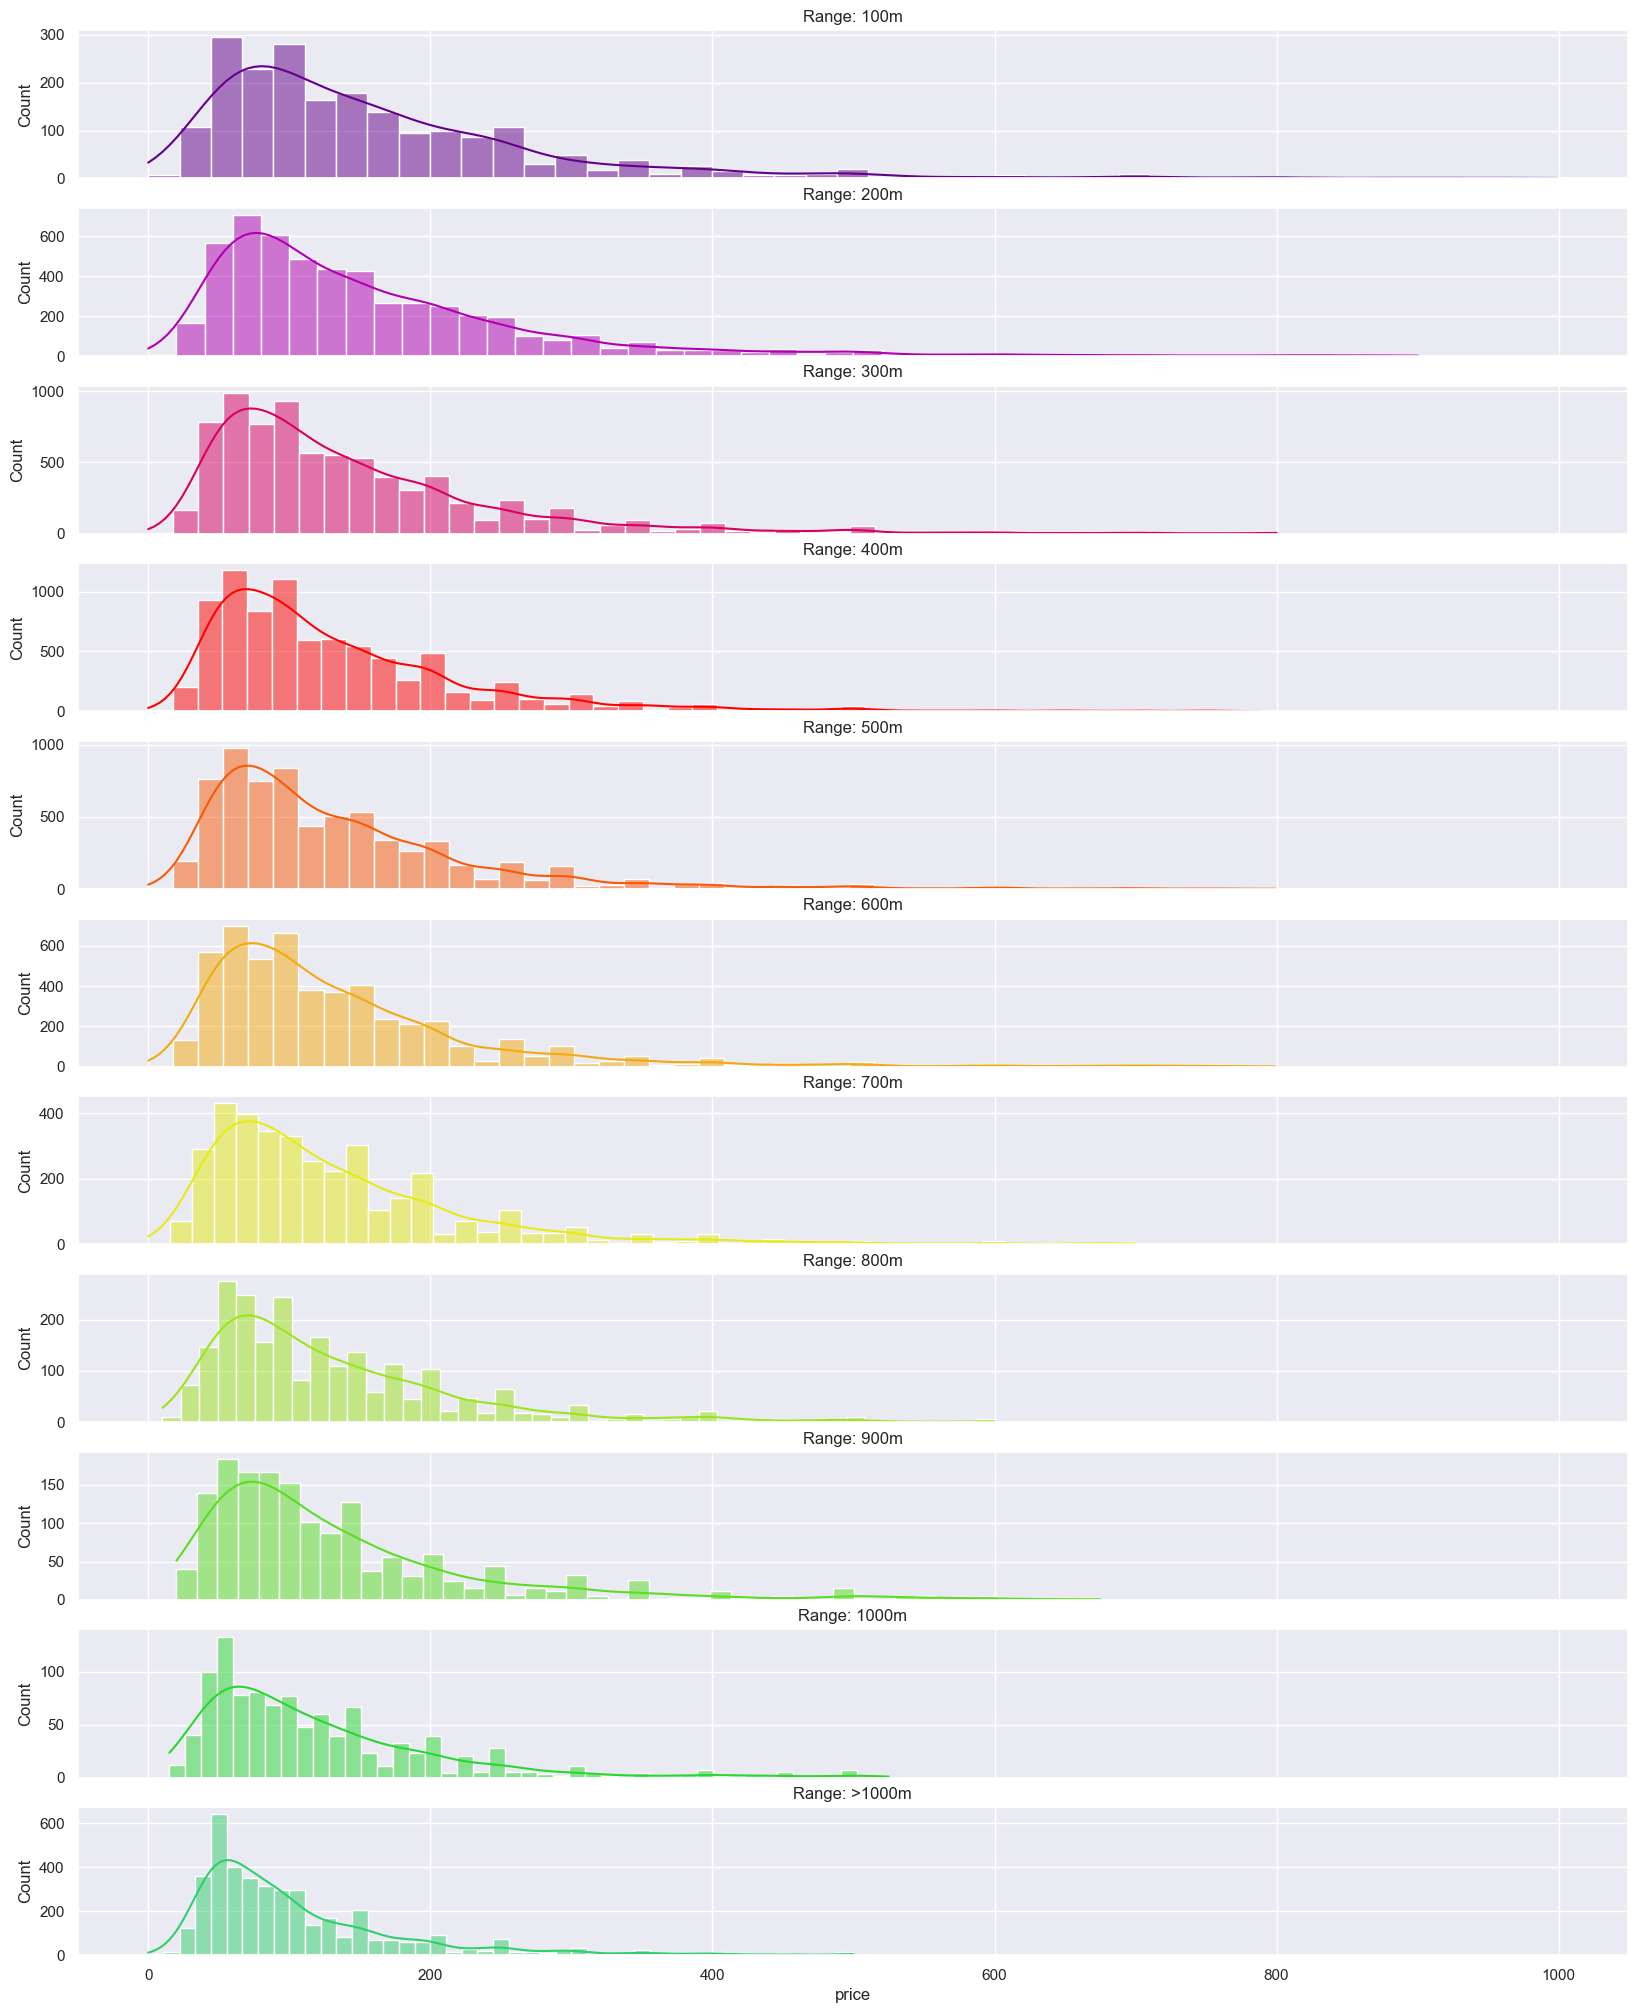

In [132]:
fig, ax = plt.subplots(11,1, figsize=(20,25), sharex=True)
sns.histplot(df_100[df_100['price'] < df_100['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[0], color=color_code[0])
ax[0].set_title('Range: 100m')
sns.histplot(df_200[df_200['price'] < df_200['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[1], color=color_code[1])
ax[1].set_title('Range: 200m')
sns.histplot(df_300[df_300['price'] < df_300['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[2], color=color_code[2])
ax[2].set_title('Range: 300m')
sns.histplot(df_400[df_400['price'] < df_400['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[3], color=color_code[3])
ax[3].set_title('Range: 400m')
sns.histplot(df_500[df_500['price'] < df_500['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[4], color=color_code[4])
ax[4].set_title('Range: 500m')
sns.histplot(df_600[df_600['price'] < df_600['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[5], color=color_code[5])
ax[5].set_title('Range: 600m')
sns.histplot(df_700[df_700['price'] < df_700['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[6], color=color_code[6])
ax[6].set_title('Range: 700m')
sns.histplot(df_800[df_800['price'] < df_800['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[7], color=color_code[7])
ax[7].set_title('Range: 800m')
sns.histplot(df_900[df_900['price'] < df_900['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[8], color=color_code[8])
ax[8].set_title('Range: 900m')
sns.histplot(df_1000[df_1000['price'] < df_1000['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[9], color=color_code[9])
ax[9].set_title('Range: 1000m')
sns.histplot(df_else[df_else['price'] < df_else['price'].quantile(0.99)]['price'], bins=45, kde=True, ax=ax[10], color=color_code[10])
ax[10].set_title('Range: >1000m')

plt.show()

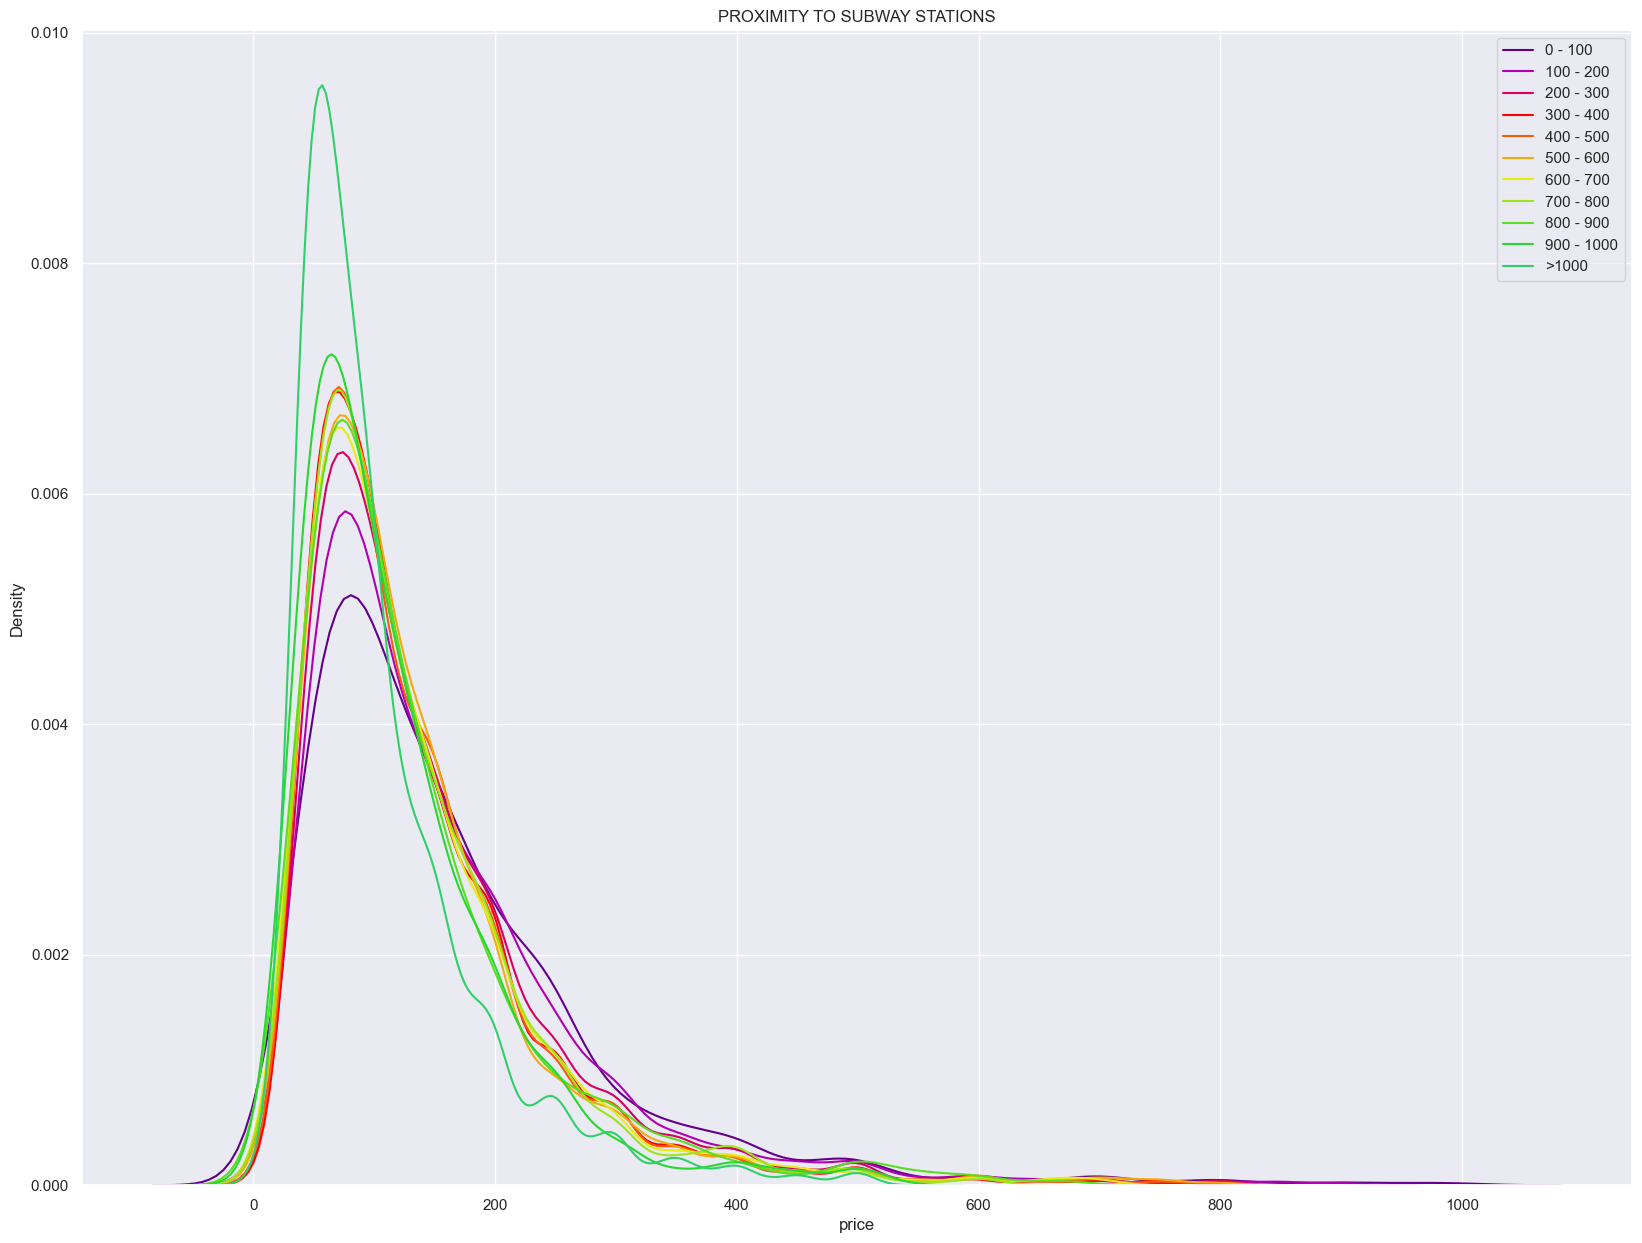

In [133]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
sns.kdeplot(df_100[df_100['price'] < df_100['price'].quantile(0.99)]['price'], ax=ax, color=color_code[0], label='0 - 100')
sns.kdeplot(df_200[df_200['price'] < df_200['price'].quantile(0.99)]['price'], ax=ax, color=color_code[1], label='100 - 200')
sns.kdeplot(df_300[df_300['price'] < df_300['price'].quantile(0.99)]['price'], ax=ax, color=color_code[2], label='200 - 300')
sns.kdeplot(df_400[df_400['price'] < df_400['price'].quantile(0.99)]['price'], ax=ax, color=color_code[3], label='300 - 400')
sns.kdeplot(df_500[df_500['price'] < df_500['price'].quantile(0.99)]['price'], ax=ax, color=color_code[4], label='400 - 500')
sns.kdeplot(df_600[df_600['price'] < df_600['price'].quantile(0.99)]['price'], ax=ax, color=color_code[5], label='500 - 600')
sns.kdeplot(df_700[df_700['price'] < df_700['price'].quantile(0.99)]['price'], ax=ax, color=color_code[6], label='600 - 700')
sns.kdeplot(df_800[df_800['price'] < df_800['price'].quantile(0.99)]['price'], ax=ax, color=color_code[7], label='700 - 800')
sns.kdeplot(df_900[df_900['price'] < df_900['price'].quantile(0.99)]['price'], ax=ax, color=color_code[8], label='800 - 900')
sns.kdeplot(df_1000[df_1000['price'] < df_1000['price'].quantile(0.99)]['price'], ax=ax, color=color_code[9], label='900 - 1000')
sns.kdeplot(df_else[df_else['price'] < df_else['price'].quantile(0.99)]['price'], ax=ax, color=color_code[10], label='>1000')
ax.set_title('PROXIMITY TO SUBWAY STATIONS')
ax.legend()
plt.show()

#### A LA SEGÜENT POTSER QUEDEN MILLOR UNS BOXPLOTS

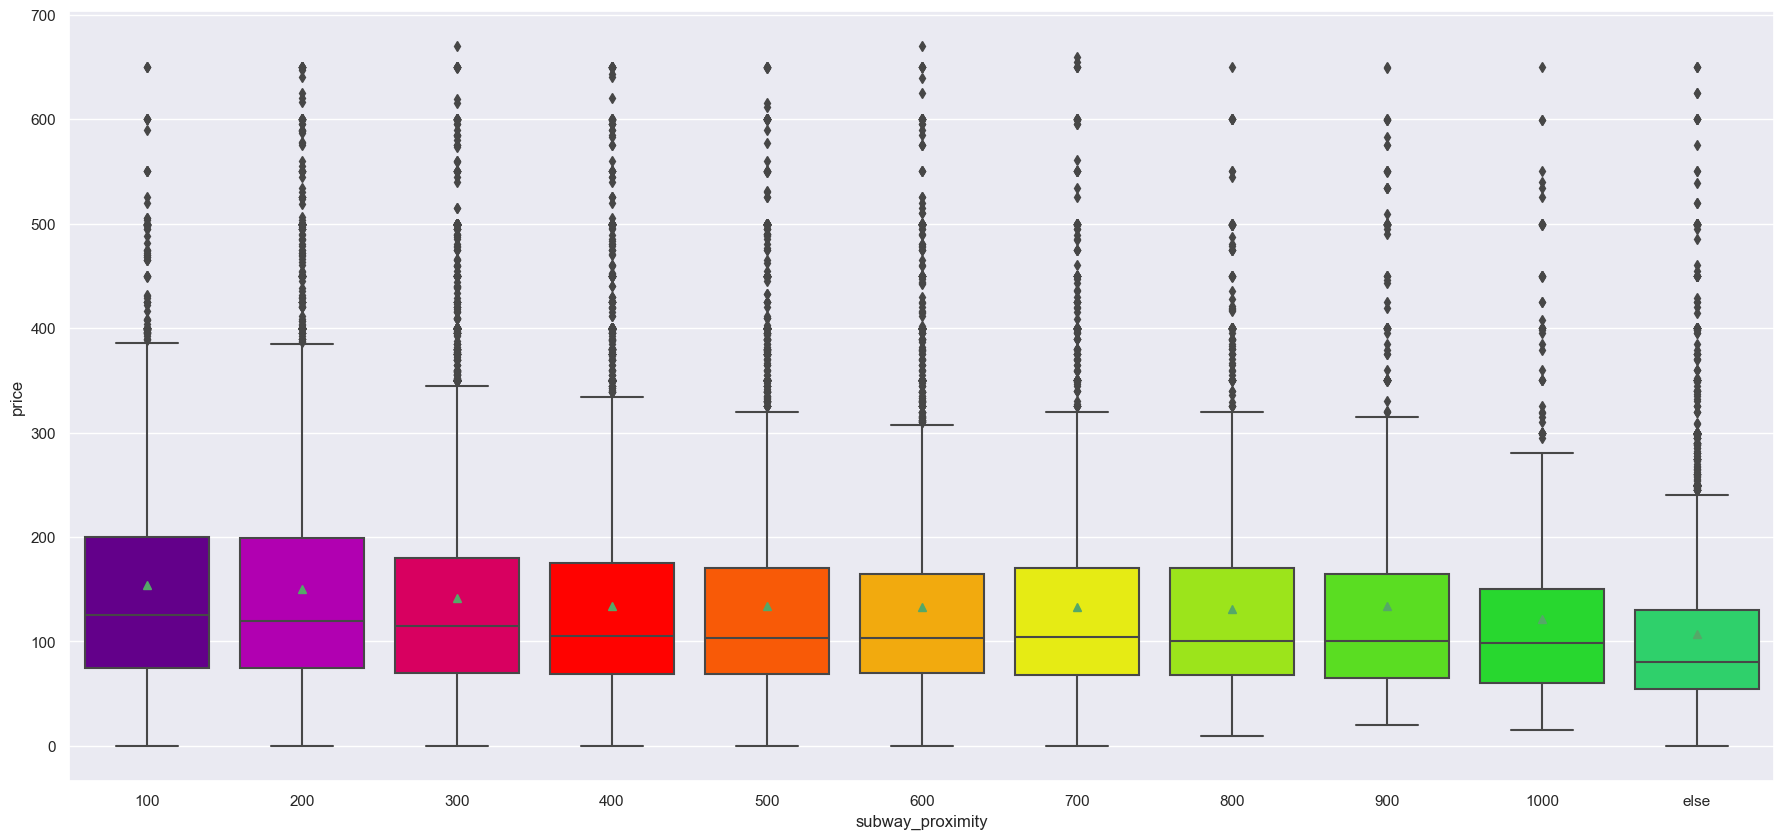

In [134]:
fig, ax = plt.subplots(1, figsize=(22,10))
sns.boxplot(df[df['price'] < clean_df['price'].quantile(0.99)], x='subway_proximity', y='price', ax=ax, showmeans=True)
for box, color in zip(ax.patches, color_code):
    box.set_facecolor(color)
plt.show()
#AQUÍ POTSER QUEDEN MILLOR UNS BOXPLOTS

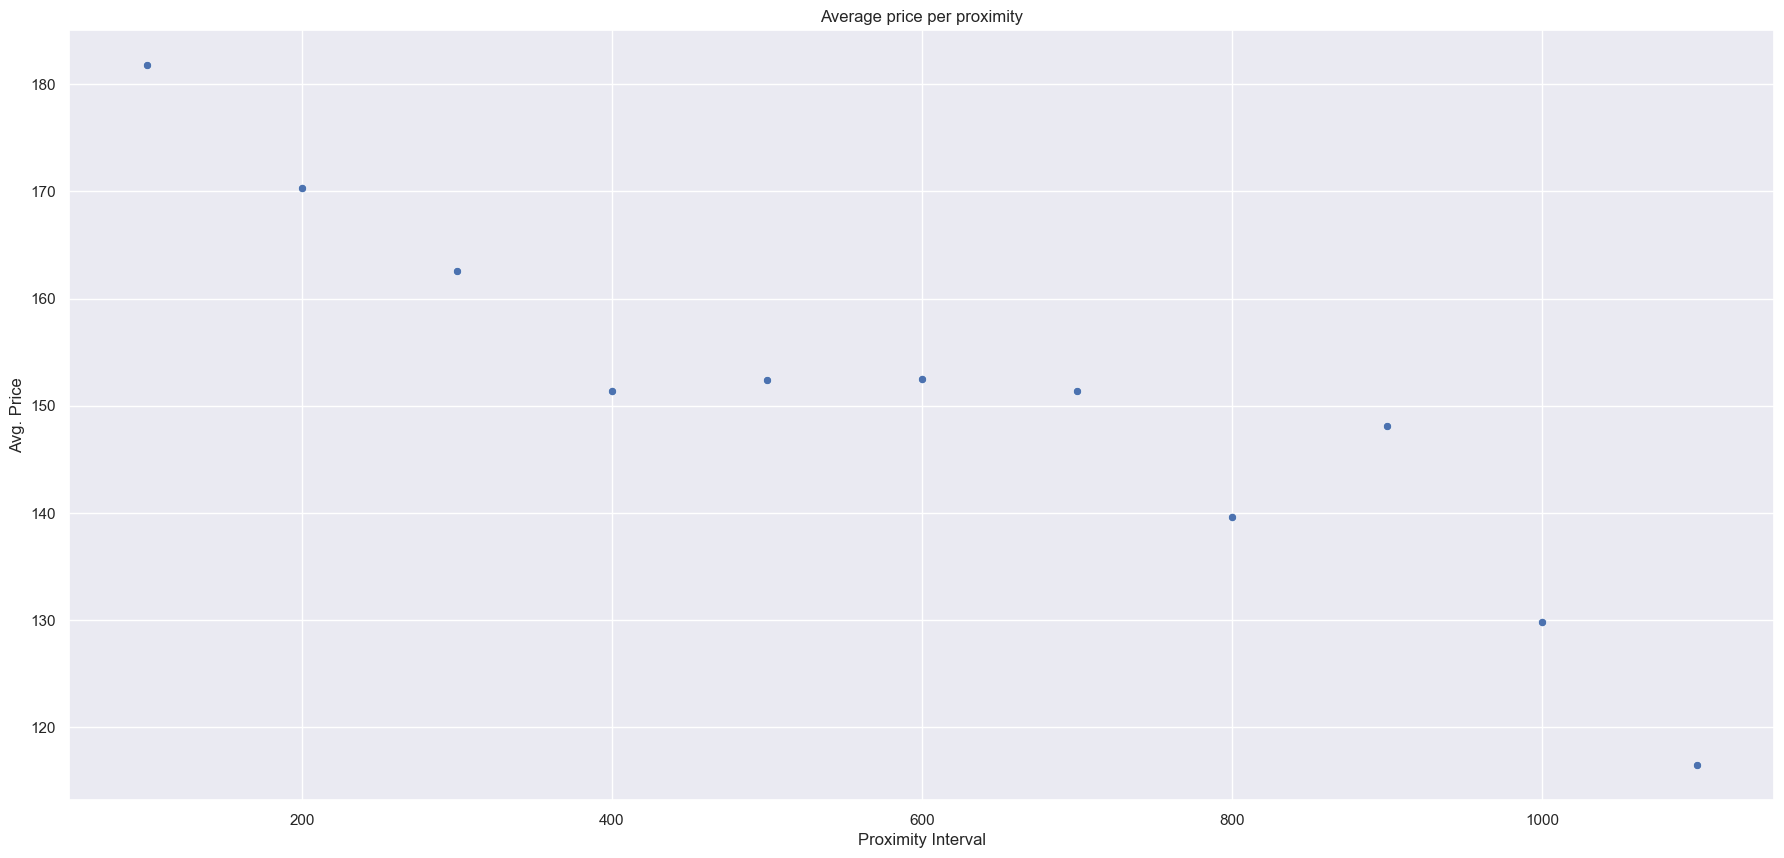

In [135]:
y = [df_100['price'].mean(),
df_200['price'].mean(),
df_300['price'].mean(),
df_400['price'].mean(),
df_500['price'].mean(),
df_600['price'].mean(),
df_700['price'].mean(),
df_800['price'].mean(),
df_900['price'].mean(),
df_1000['price'].mean(),
df_else['price'].mean()]
x= [100,200,300,400,500,600,700,800,900,1000,1100]

fig, ax = plt.subplots(1, figsize=(22,10))
sns.scatterplot(x=x, y=y, ax=ax)
plt.title("Average price per proximity")
plt.ylabel("Avg. Price")
plt.xlabel("Proximity Interval")
plt.show()

## 3. Prediction

### Feature selection

Let's visualize the heatmap of the correlation matrix of the features in <code>clean_df</code>

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


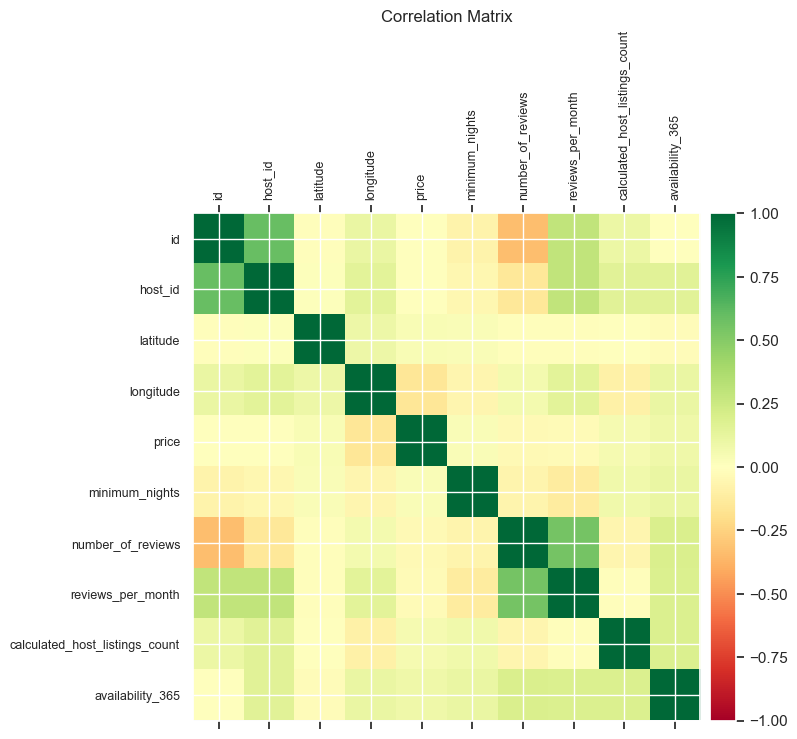

================== Correlations with our candidate target: Price ==================


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,longitude,number_of_reviews,reviews_per_month,id,host_id,minimum_nights,latitude,calculated_host_listings_count,availability_365,price
price,-0.155298,-0.035924,-0.030623,-0.006696,0.006263,0.025501,0.031344,0.052895,0.078276,1.0


In [106]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
plt.figure(figsize=(7,7))
plt.title("Correlation Matrix")
ax = plt.gca()
matrix = ax.matshow(clean_df.corr(), vmin=-1, vmax=1, cmap='RdYlGn')
plt.xticks(range(clean_df.select_dtypes(['number']).shape[1]), clean_df.select_dtypes(['number']).columns, fontsize=9, rotation=90)
plt.yticks(range(clean_df.select_dtypes(['number']).shape[1]), clean_df.select_dtypes(['number']).columns, fontsize=9)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(matrix, cax=cax)
plt.show()


print(f"================== Correlations with our candidate target: Price ==================")
target = clean_df.corr()['price']
display(pd.DataFrame(target.sort_values()).transpose())

We will drop the following features given their low correlation with `price`:

In [107]:
df2 = clean_df.drop(['longitude','id', 'host_id', 'latitude', 'name', 'last_review', 'host_name'], axis=1)
df2.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,subway_proximity
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,700
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,else
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,500
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,300
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,600


In [108]:
df2 = pd.get_dummies(df2)
df2.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,subway_proximity_200,subway_proximity_300,subway_proximity_400,subway_proximity_500,subway_proximity_600,subway_proximity_700,subway_proximity_800,subway_proximity_900,subway_proximity_1000,subway_proximity_else
0,149,1,9,0.21,6,365,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,225,1,45,0.38,2,355,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,89,1,270,4.64,1,194,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,80,10,9,0.10,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,200,3,74,0.59,1,129,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [109]:
X = df2.drop('price', axis=1)
y = df2.price 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print("Training linear regression model...")
linear_regression = LinearRegression().fit(X_train, y_train)

print("Training random forest regression model...")
random_forest = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
random_forest.fit(X_train, y_train)

print("Training gradient boosting regression model...")
gradient_boosting = GradientBoostingRegressor(n_estimators=100, max_depth=7, random_state=0)
gradient_boosting.fit(X_train, y_train)

print("Obtaining predictions...")
y_predict_lr = linear_regression.predict(X_test)
y_predict_rf = random_forest.predict(X_test)
y_predict_gb = gradient_boosting.predict(X_test)

print(f"{' MSE ':=^50}\n\tLinear Regression: {mean_squared_error(y_test, y_predict_lr)}\n\tRandom Forest Regression: {mean_squared_error(y_test, y_predict_rf)}\n\tGradient Boosting Regression: {mean_squared_error(y_test, y_predict_gb)}")


Training linear regression model...
Training random forest regression model...
Training gradient boosting regression model...
Obtaining predictions...
====================== MSE =======================
	Linear Regression: 1046604017290299.5
	Random Forest Regression: 34891.93672045434
	Gradient Boosting Regression: 36961.690977641905


In [110]:
import shap
shap.initjs() 
explainer=shap.Explainer(random_forest)
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


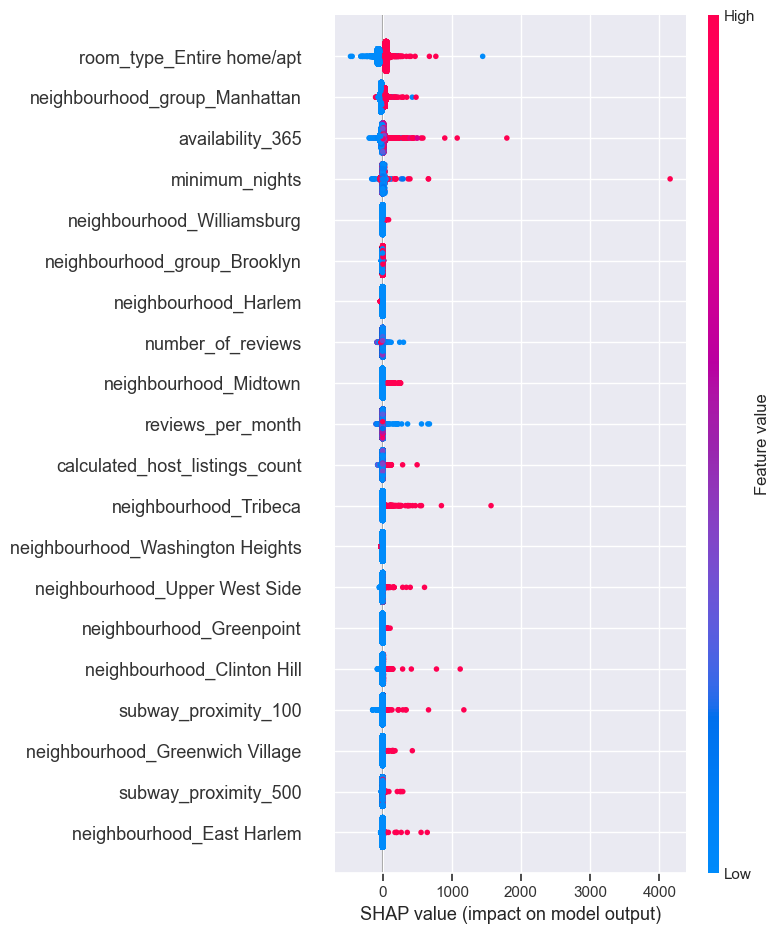

In [111]:
shap.summary_plot(shap_values, X)

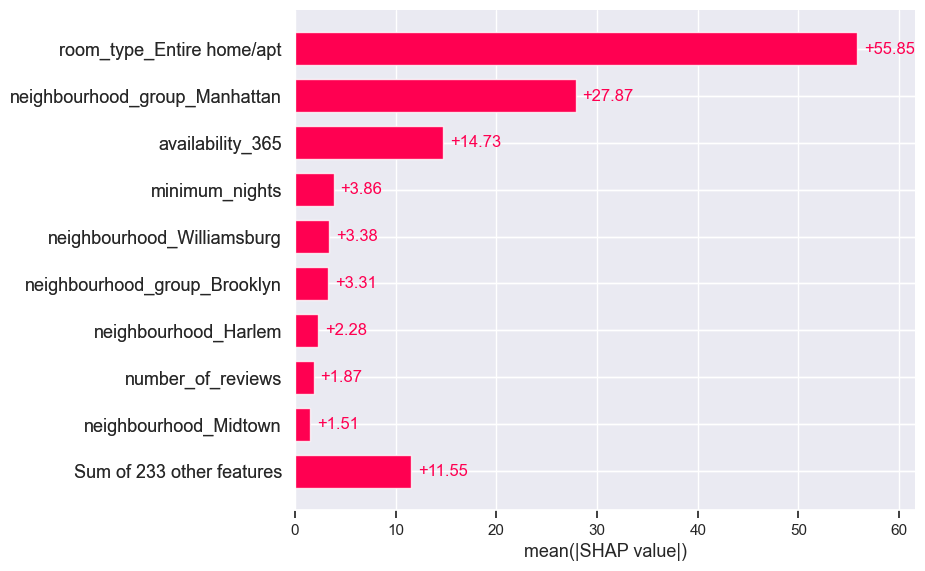

In [112]:
shap.plots.bar(shap_values)